In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
train = pd.read_csv('/Users/seeming.tan/Desktop/train20.csv')
test = pd.read_csv('/Users/seeming.tan/Desktop/test20.csv')

In [6]:
training = train.drop(['id'],axis=1)
testing = test.drop(['id'],axis=1)

training = training.loc[:, training.columns != 'suspicious_user']
testing = testing.loc[:]


features = training.columns
target = 'suspicious_user'

X_train, X_test = training, testing
y_train = train['suspicious_user']

In [4]:
import warnings
warnings.filterwarnings("ignore")


model_factory = [
    RandomForestClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    SVC(probability = True)
]

for model in model_factory:
    model.seed = 42
    num_folds = 10
    
    scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
    scores = cross_validate(model, X_train, y_train, cv=num_folds, scoring=scoring, n_jobs=6)


    sorted(scores.keys())
    fit_time = scores['fit_time'].mean()
    score_time = scores['score_time'].mean()
    train_accuracy = scores['train_accuracy'].mean()
    test_accuracy = scores['test_accuracy'].mean()
    precision = scores['test_precision_macro'].mean()
    recall = scores['test_recall_macro'].mean()
    f1 = scores['test_f1_weighted'].mean()
    roc = scores['test_roc_auc'].mean()
    
    
    models_tree = pd.DataFrame({
        'Model'         : [model],
        'Fitting time'  : [fit_time],
        'Scoring time'  : [score_time],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy' : [test_accuracy],
        'Precision'     : [precision],
        'Recall'        : [recall],
        'F1_score'      : [f1],
        'AUC_ROC'       : [roc]}
        ,columns = ['Fitting time', 'Scoring time', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1_score','AUC_ROC'])
    
    print(models_tree)

#XGBRegressor(nthread=1),
#MLPRegressor(),

   Fitting time  Scoring time  Train Accuracy  Test Accuracy  Precision  \
0      0.022498         0.017        0.990243       0.838736   0.886738   

     Recall  F1_score   AUC_ROC  
0  0.838736  0.816227  0.884911  
   Fitting time  Scoring time  Train Accuracy  Test Accuracy  Precision  \
0      0.003101      0.010998        0.724754       0.757692   0.731887   

     Recall  F1_score  AUC_ROC  
0  0.757692  0.700725  0.85503  
   Fitting time  Scoring time  Train Accuracy  Test Accuracy  Precision  \
0      0.003701      0.009001             1.0       0.850549   0.871874   

     Recall  F1_score   AUC_ROC  
0  0.850549  0.846397  0.850549  
   Fitting time  Scoring time  Train Accuracy  Test Accuracy  Precision  \
0        0.0039        0.0183        0.815931       0.697527   0.689842   

     Recall  F1_score   AUC_ROC  
0  0.697527  0.643437  0.674556  
   Fitting time  Scoring time  Train Accuracy  Test Accuracy  Precision  \
0      0.065701        0.0102        0.998725      

In [5]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''
    
    def __init__(self, model, unlabled_data, features, target, sample_rate=1, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )
        
        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''        
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])
        
        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

In [6]:
model = PseudoLabeler(
    RandomForestClassifier(),
    test,
    features,
    target,
    sample_rate = 1
)

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted']
model.fit(X_train, y_train)
pred = model.predict(X_test)
scores = cross_validate(model, X_train, y_train, cv=num_folds, scoring=scoring, n_jobs=6)


sorted(scores.keys())
fit_time = scores['fit_time'].mean()
score_time = scores['score_time'].mean()
train_accuracy = scores['train_accuracy'].mean()
test_accuracy = scores['test_accuracy'].mean()
precision = scores['test_precision_macro'].mean()
recall = scores['test_recall_macro'].mean()
f1 = scores['test_f1_weighted'].mean()
    
    
    
models_tree = pd.DataFrame({
    'Fitting time'  : [fit_time],
    'Scoring time'  : [score_time],
    'Train Accuracy': [train_accuracy],
    'Test Accuracy' : [test_accuracy],
    'Precision'     : [precision],
    'Recall'        : [recall],
    'F1_score'      : [f1]}
    ,columns = ['Fitting time', 'Scoring time', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1_score'])
    
print(models_tree)

   Fitting time  Scoring time  Train Accuracy  Test Accuracy  Precision  \
0      0.767816      0.011304        0.990669       0.862251      0.725   

     Recall  F1_score  
0  0.681048  0.917652  


In [ ]:
sub = pd.DataFrame(data = pred, columns=['suspicious_user'])
sub['id'] = test['id']
sub.to_csv('rfc_newversion.csv', index='False')

In [ ]:
sub['suspicious_user'].value_counts()

In [7]:
df = pd.read_csv('/Users/seeming.tan/Desktop/rfc_newversion.csv')
train = pd.read_csv('/Users/seeming.tan/Desktop/train20.csv')
test = pd.read_csv('/Users/seeming.tan/Desktop/test20.csv')
df = pd.merge(test, df, left_on= 'id', right_on='id', how = 'inner')
df

,id,deal_price,deal_amount,cancel_price,cancel_amount,similar_amount,bidspread_amount,bidspread_count,total_vol_percent,cancel_buy_rate,vol1_count,suspicious_user
0,853917,6.662553,4.729191e+06,6.695135,6.163180e+06,0.000000,1.223180e+05,2,2.201903e-01,1,13,1
1,586865,6.691688,3.481309e+06,6.620177,2.063387e+06,363.539232,2.010000e+04,2,1.598884e-01,0,4,1
2,750798,6.572414,3.267846e+06,6.465435,4.002174e+06,0.000000,6.685463e+04,1,1.540077e-01,1,3,0
3,643460,6.625833,2.891093e+06,6.723600,6.150884e+06,0.000000,0.000000e+00,0,1.347631e-01,2,0,0
4,1266546,6.074000,2.623106e+06,6.030476,3.074549e+06,0.000000,0.000000e+00,0,1.335264e-01,0,9,0
5,681178,5.904167,2.395665e+06,6.346842,1.674706e+06,0.000000,4.000000e+01,4,1.239536e-01,1,6,0
6,1236575,7.269655,2.736144e+06,7.077179,4.896677e+06,0.000000,1.071811e+05,1,1.153190e-01,1,2,0
7,634759,6.734423,2.151363e+06,1147.983333,5.372261e+08,0.000000,5.367321e+08,17,1.017321e-01,0,3,1
8,733125,7.445000,2.327524e+06,7.278333,8.034660e+05,0.000000,0.000000e+00,0,9.795697e-02,0,3,0
9,670163,6.890484,2.166473e+06,6.805556,3.371529e+06,0.000000,7.930561e+04,1,9.770844e-02,1,3,0


In [8]:
df = pd.merge(df, train, how = 'outer')
df['suspicious_user'].value_counts()

0    36918
1     5624
Name: suspicious_user, dtype: int64

In [9]:
df = df.drop(['id','deal_amount','cancel_amount'],axis=1)

In [10]:
X = df.loc[:, df.columns != 'suspicious_user']
y = df['suspicious_user']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, val_X, y_train, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Best parameters : {'validation_fraction': {0: 0.05, 1: 0.95}}


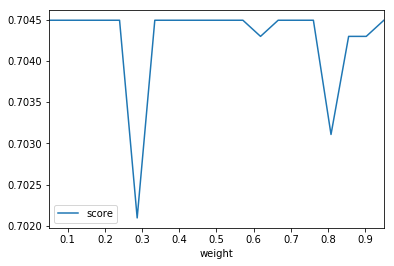

In [9]:
import warnings
from sklearn.model_selection import GridSearchCV


weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid={
        'validation_fraction': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)

grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [11]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio= 0.3, kind='borderline1',random_state=42)
X_train_res , y_train_res = sm.fit_sample(X_train,y_train)

In [12]:
np.array(np.unique(y_train_res, return_counts=True)).T

array([[    0, 23650],
       [    1,  7095]], dtype=int64)

In [23]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_res, y_train_res, scoring=scoring, return_train_score = True, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_train_accuracy = scores['train_accuracy'].mean()
LR_test_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [24]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_res, y_train_res, return_train_score = True, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_train_accuracy = scores['train_accuracy'].mean()
dtree_test_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [25]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_res, y_train_res, return_train_score = True, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_train_accuracy = scores['train_accuracy'].mean()
bayes_test_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [26]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_res, y_train_res, return_train_score = True, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_train_accuracy = scores['train_accuracy'].mean()
forest_test_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [27]:
GBC = GradientBoostingClassifier()

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(GBC, X_train_res, y_train_res, return_train_score = True, scoring=scoring, cv=10)

sorted(scores.keys())
GBC_fit_time = scores['fit_time'].mean()
GBC_score_time = scores['score_time'].mean()
GBC_train_accuracy = scores['train_accuracy'].mean()
GBC_test_accuracy = scores['test_accuracy'].mean()
GBC_precision = scores['test_precision_macro'].mean()
GBC_recall = scores['test_recall_macro'].mean()
GBC_f1 = scores['test_f1_weighted'].mean()
GBC_roc = scores['test_roc_auc'].mean()

In [28]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_res, y_train_res, return_train_score = True, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_train_accuracy = scores['train_accuracy'].mean()
KNN_test_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [29]:
models_tree = pd.DataFrame({
    'Model'         : ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Bayes', 'Gradient Boosting'],
    'Fitting time'  : [LR_fit_time, dtree_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time, GBC_fit_time],
    'Scoring time'  : [LR_score_time, dtree_score_time,  forest_score_time, KNN_score_time, bayes_score_time, GBC_score_time],
    'Train Accuracy': [LR_train_accuracy, dtree_train_accuracy,  forest_train_accuracy, KNN_train_accuracy, bayes_train_accuracy, GBC_train_accuracy],
    'Test Accuracy' : [LR_test_accuracy, dtree_test_accuracy, forest_test_accuracy, KNN_test_accuracy, bayes_test_accuracy, GBC_test_accuracy],
    'Precision'     : [LR_precision, dtree_precision, forest_precision, KNN_precision, bayes_precision, GBC_precision],
    'Recall'        : [LR_recall, dtree_recall,  forest_recall, KNN_recall, bayes_recall, GBC_recall],
    'F1_score'      : [LR_f1, dtree_f1, forest_f1, KNN_f1, bayes_f1, GBC_f1],
    'AUC_ROC'       : [LR_roc, dtree_roc, forest_roc, KNN_roc, bayes_roc, GBC_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_tree.sort_values(by='F1_score', ascending=False)

,Model,Fitting time,Scoring time,Train Accuracy,Test Accuracy,Precision,Recall,F1_score,AUC_ROC
2,Random Forest,0.226182,0.027902,0.997087,0.977525,0.975249,0.960973,0.977352,0.994233
1,Decision Tree,0.108578,0.005672,0.999299,0.972093,0.961416,0.959904,0.972063,0.960522
5,Gradient Boosting,1.187712,0.021213,0.953351,0.949846,0.946590,0.909635,0.948762,0.988923
3,K-Nearest Neighbors,0.603806,0.963799,0.928050,0.894194,0.855550,0.841292,0.893110,0.922882
0,Logistic Regression,0.166593,0.004902,0.799425,0.797203,0.871625,0.563316,0.731542,0.824744
4,Bayes,0.011196,0.008000,0.771695,0.771702,0.723034,0.507523,0.677231,0.527202


In [30]:
params={'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)],
        'max_features': ['auto', 'sqrt'],
        'max_depth': np.linspace(1, 100, 100, endpoint=True),
        'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True), #np.linspace(0.1, 1.0, 10, endpoint=True)
        'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True), #np.linspace(0.1, 0.5, 5, endpoint=True)
        'bootstrap': [True, False]
       }

In [31]:
rfc = RandomForestClassifier()

# Random search of parameters, using 10 fold cross validation, 
# search across 200 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = params, n_iter = 200, cv = 10, verbose=2, random_state=42, n_jobs = 7)

# Fit the random search model
rfc_random.fit(val_X, val_y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done 243 tasks      | elapsed:   11.7s
[Parallel(n_jobs=7)]: Done 649 tasks      | elapsed:   25.8s
[Parallel(n_jobs=7)]: Done 1215 tasks      | elapsed:   45.3s
[Parallel(n_jobs=7)]: Done 1945 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 1987 out of 2000 | elapsed:  1.3min remaining:    0.4s
[Parallel(n_jobs=7)]: Done 2000 out of 2000 | elapsed:  1.3min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=7,
          param_distributions={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,..., 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'bootstrap': [True, False]},
          pre_di

In [32]:
rfc_random.best_params_

{'n_estimators': 61,
 'min_samples_split': 0.2,
 'min_samples_leaf': 0.1,
 'max_features': 'sqrt',
 'max_depth': 29.0,
 'bootstrap': False}

In [41]:
rfc_model = RandomForestClassifier(n_estimators= 61,
                                   min_samples_split= 0.2,
                                   min_samples_leaf= 0.1, 
                                   max_features= 'sqrt',
                                   max_depth= 29,
                                   bootstrap= False,
                                   random_state = 42)

In [42]:
rfc_model.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=29, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
y_pred_rfc = rfc_model.predict(X_test)

In [44]:
print ("Train Accuracy :: ", accuracy_score(y_train_res, rfc_model.predict(X_train_res)))
print ("Test Accuracy  :: ", accuracy_score(y_test, y_pred_rfc))

Train Accuracy ::  0.8972190600097577
Test Accuracy  ::  0.9501704078035021


In [45]:
print(confusion_matrix(y_test, y_pred_rfc))

[[7368    9]
 [ 415  717]]


In [46]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7377
           1       0.99      0.63      0.77      1132

   micro avg       0.95      0.95      0.95      8509
   macro avg       0.97      0.82      0.87      8509
weighted avg       0.95      0.95      0.95      8509



In [47]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred_rfc)
roc_auc

0.8160861090075112

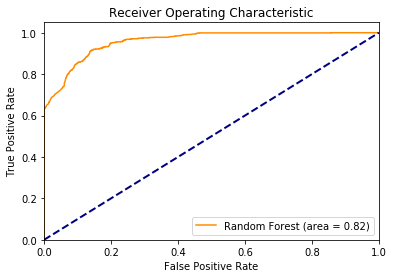

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, rfc_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
params={'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
        'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': np.linspace(1, 100, 100, endpoint=True),
        'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
        'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True)
       }
        

In [50]:
gbm = GradientBoostingClassifier()

# Random search of parameters, using 10 fold cross validation, 
# search across 200 different combinations, and use all available cores
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = params, n_iter = 200, cv = 10, verbose=2, random_state=42, n_jobs = 6)

# Fit the random search model
gbm_random.fit(val_X, val_y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done 356 tasks      | elapsed:    8.8s
[Parallel(n_jobs=6)]: Done 728 tasks      | elapsed:   21.2s
[Parallel(n_jobs=6)]: Done 1422 tasks      | elapsed:   40.6s
[Parallel(n_jobs=6)]: Done 1989 out of 2000 | elapsed:  1.0min remaining:    0.2s
[Parallel(n_jobs=6)]: Done 2000 out of 2000 | elapsed:  1.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=200, n_jobs=6,
          param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001], 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': array([  1.,   2., ...,  99., 100.]), 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scori

In [51]:
gbm_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 0.30000000000000004,
 'min_samples_leaf': 0.1,
 'max_features': 'auto',
 'max_depth': 74.0,
 'learning_rate': 0.15}

In [52]:
gbm_model = GradientBoostingClassifier(n_estimators= 100,
                                       min_samples_split= 0.3,
                                       min_samples_leaf= 0.1, 
                                       max_features= 'auto',
                                       max_depth= 74,
                                       learning_rate= 0.15,
                                       random_state = 42)

In [53]:
gbm_model.fit(X_train_res, y_train_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=74,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.3,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [54]:
y_pred_gbm = gbm_model.predict(X_test)

In [55]:
# 0.3
from sklearn.metrics import accuracy_score
print ("Train Accuracy :: ", accuracy_score(y_train, gbm_model.predict(X_train)))
print ("Test Accuracy  :: ", accuracy_score(y_test, y_pred_gbm))

Train Accuracy ::  0.9417835892161904
Test Accuracy  ::  0.9383006228699025


In [56]:
# 0.3
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_gbm))
print(classification_report(y_test, y_pred_gbm))

[[7120  257]
 [ 268  864]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7377
           1       0.77      0.76      0.77      1132

   micro avg       0.94      0.94      0.94      8509
   macro avg       0.87      0.86      0.87      8509
weighted avg       0.94      0.94      0.94      8509



In [57]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred_gbm)
roc_auc

0.8642064366805241

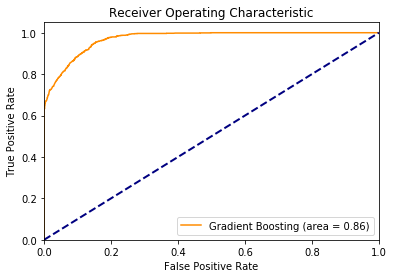

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, gbm_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Gradient Boosting (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()